# Statistical Models
In this notebook I try out various different statistical models on the long data.

In [1]:
import polars as pl
from matplotlib import pyplot as plt

In [4]:
df_long = pl.read_parquet("../data/processed_data/df_long.parquet")
test = pl.read_parquet("../data/processed_data/fourier+trend+holidays_test.parquet")

In [5]:
test

ds,unique_id,y,is_holiday,holiday_name,days_to_holiday,days_since_holiday,num_holidays,sin1_7,sin2_7,sin3_7,cos1_7,cos2_7,cos3_7,trend
date,str,f64,bool,str,i64,i64,i64,f32,f32,f32,f32,f32,f32,f32
2025-01-01,"""""Bubble tea""""",1724.0,true,"""New Year's Day""",19,7,1,0.781832,0.974928,0.433884,0.62349,-0.222521,-0.900969,1.0
2025-01-02,"""""Bubble tea""""",1816.0,false,"""""",18,1,0,0.974928,-0.433884,-0.781832,-0.222521,-0.900969,0.62349,2.0
2025-01-03,"""""Bubble tea""""",1787.0,false,"""""",17,2,0,0.433884,-0.781831,0.974928,-0.900969,0.62349,-0.22252,3.0
2025-01-04,"""""Bubble tea""""",2102.0,false,"""""",16,3,0,-0.433884,0.781832,-0.974928,-0.900969,0.62349,-0.222521,4.0
2025-01-05,"""""Bubble tea""""",2020.0,false,"""""",15,4,0,-0.974928,0.433884,0.781831,-0.222521,-0.900969,0.62349,5.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-11-27,"""""Tea""""",1239.0,true,"""Thanksgiving Day""",28,16,1,0.974925,-0.433909,-0.781843,-0.222535,-0.900957,0.623475,331.0
2025-11-28,"""""Tea""""",1239.0,false,"""""",27,1,0,0.433884,-0.781832,0.974928,-0.900969,0.623489,-0.222519,332.0
2025-11-29,"""""Tea""""",1218.0,false,"""""",26,2,0,-0.433897,0.78185,-0.974918,-0.900962,0.623466,-0.222567,333.0


**To Predict:** Views (i64)

**Features:** Date (date), Drink (str)

In [4]:
train = df_long.filter(pl.col("Date") < pl.date(2024,1,1))
test = df_long.filter(pl.col("Date") >= pl.date(2024,1,1))

In [5]:
test

Date,Drink,Views
date,str,i64
2024-01-01,"""""Matcha""""",2538
2024-01-02,"""""Matcha""""",2561
2024-01-03,"""""Matcha""""",2561
2024-01-04,"""""Matcha""""",2746
2024-01-05,"""""Matcha""""",2766
…,…,…
2025-11-27,"""""Iced coffee""""",131
2025-11-28,"""""Iced coffee""""",141
2025-11-29,"""""Iced coffee""""",134


## Autoregressive Model

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA

In [7]:
# Convert train DataFrame to proper time series for statsmodels
train_ts = (
    train
    .sort("Date")
    .select(["Date", "Views"])
    .to_pandas()
    .set_index("Date")["Views"]
)

test_ts = (
    test
    .sort("Date")
    .select(["Date", "Views"])
    .to_pandas()
    .set_index("Date")["Views"]
)

# Now this will work
mod = AutoReg(train_ts, lags=3, trend='ct')
res = mod.fit(cov_type='HC3')

c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [13]:
# Import additional libraries for model evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(actual, predicted, model_name):
    """Calculate and print evaluation metrics"""
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    print(f"\n{model_name} Performance:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")
    
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

## Baseline Models
Let's start with simple baseline models to establish a performance benchmark.

In [14]:
# Naive Forecast - last value carries forward
naive_pred = np.full(len(test_ts), train_ts.iloc[-1])

# Seasonal Naive - same value from last year
seasonal_period = 7  # weekly seasonality
seasonal_naive_pred = []
for i in range(len(test_ts)):
    idx = len(train_ts) - seasonal_period + (i % seasonal_period)
    if idx >= 0 and idx < len(train_ts):
        seasonal_naive_pred.append(train_ts.iloc[idx])
    else:
        seasonal_naive_pred.append(train_ts.iloc[-1])
seasonal_naive_pred = np.array(seasonal_naive_pred)

# Moving Average
window = 7
ma_pred = np.full(len(test_ts), train_ts.tail(window).mean())

# Evaluate baselines
results = {}
results['Naive'] = evaluate_model(test_ts.values, naive_pred, "Naive Forecast")
results['Seasonal_Naive'] = evaluate_model(test_ts.values, seasonal_naive_pred, "Seasonal Naive")
results['Moving_Average'] = evaluate_model(test_ts.values, ma_pred, "Moving Average")


Naive Forecast Performance:
MAE: 1067.89
RMSE: 1671.90
MAPE: inf%

Seasonal Naive Performance:
MAE: 1172.70
RMSE: 1647.49
MAPE: nan%

Moving Average Performance:
MAE: 949.60
RMSE: 1406.13
MAPE: inf%


C:\Users\cleo7\AppData\Local\Temp\ipykernel_11160\2840208749.py:9: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual - predicted) / actual)) * 100
C:\Users\cleo7\AppData\Local\Temp\ipykernel_11160\2840208749.py:9: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual - predicted) / actual)) * 100
C:\Users\cleo7\AppData\Local\Temp\ipykernel_11160\2840208749.py:9: RuntimeWarning: invalid value encountered in divide
  mape = np.mean(np.abs((actual - predicted) / actual)) * 100
C:\Users\cleo7\AppData\Local\Temp\ipykernel_11160\2840208749.py:9: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual - predicted) / actual)) * 100


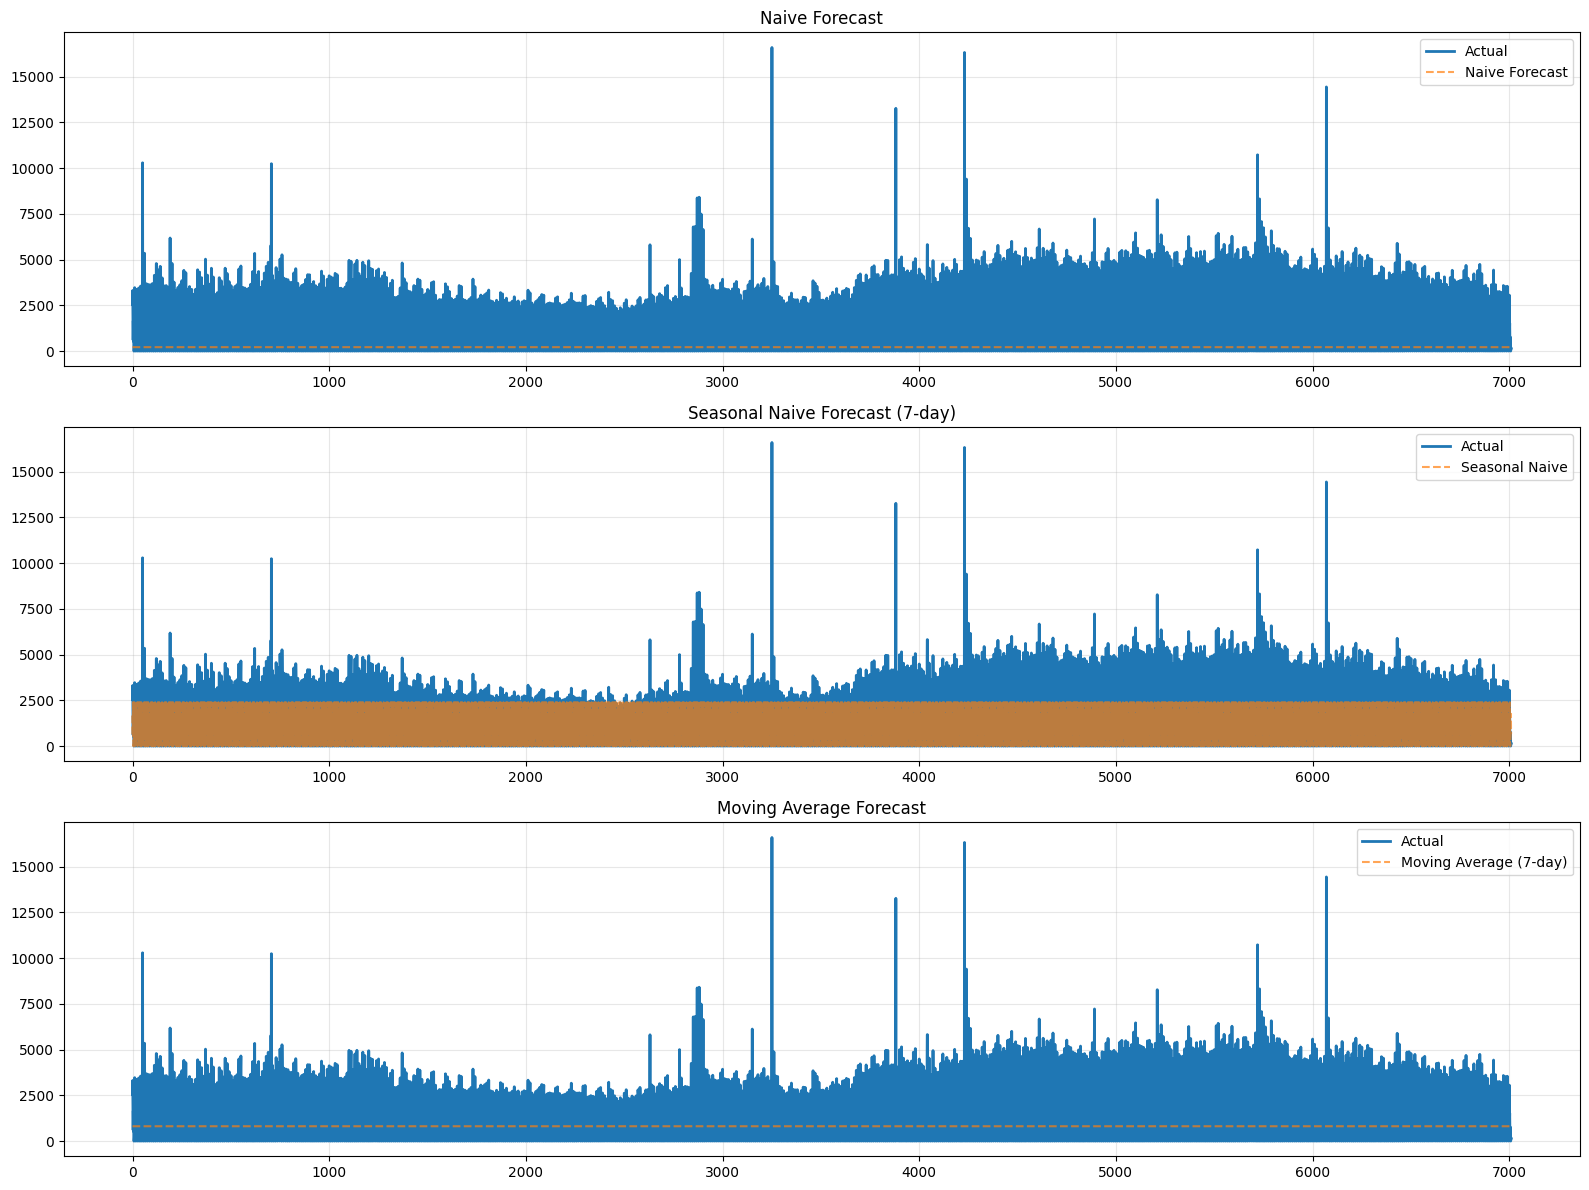

In [15]:
# Plot baseline models
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Naive
axes[0].plot(test_ts.values, label='Actual', linewidth=2)
axes[0].plot(naive_pred, label='Naive Forecast', alpha=0.7, linestyle='--')
axes[0].set_title('Naive Forecast')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Seasonal Naive
axes[1].plot(test_ts.values, label='Actual', linewidth=2)
axes[1].plot(seasonal_naive_pred, label='Seasonal Naive', alpha=0.7, linestyle='--')
axes[1].set_title('Seasonal Naive Forecast (7-day)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Moving Average
axes[2].plot(test_ts.values, label='Actual', linewidth=2)
axes[2].plot(ma_pred, label='Moving Average (7-day)', alpha=0.7, linestyle='--')
axes[2].set_title('Moving Average Forecast')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Exponential Smoothing Models
Test Simple, Double, and Triple (Holt-Winters) Exponential Smoothing.

In [16]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

# Simple Exponential Smoothing
ses_model = SimpleExpSmoothing(train_ts)
ses_fit = ses_model.fit()
ses_pred = ses_fit.forecast(steps=len(test_ts))

results['Simple_ES'] = evaluate_model(test_ts.values, ses_pred.values, "Simple Exponential Smoothing")


Simple Exponential Smoothing Performance:
MAE: 1026.11
RMSE: 1362.94
MAPE: inf%


c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\cleo7\AppData\Local\Temp\ipykernel_11160\2840208749.py:9: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual - predicted) / actual)) * 100


In [17]:
# Holt's Linear Trend Method (Double Exponential Smoothing)
des_model = ExponentialSmoothing(train_ts, trend='add', seasonal=None)
des_fit = des_model.fit()
des_pred = des_fit.forecast(steps=len(test_ts))

results['Double_ES'] = evaluate_model(test_ts.values, des_pred.values, "Double Exponential Smoothing (Holt)")

c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



Double Exponential Smoothing (Holt) Performance:
MAE: 1010.28
RMSE: 1357.01
MAPE: inf%


c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\cleo7\AppData\Local\Temp\ipykernel_11160\2840208749.py:9: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual - predicted) / actual)) * 100


In [18]:
# Holt-Winters (Triple Exponential Smoothing) - Additive
hw_add_model = ExponentialSmoothing(train_ts, trend='add', seasonal='add', seasonal_periods=7)
hw_add_fit = hw_add_model.fit()
hw_add_pred = hw_add_fit.forecast(steps=len(test_ts))

results['HW_Additive'] = evaluate_model(test_ts.values, hw_add_pred.values, "Holt-Winters (Additive)")

c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



Holt-Winters (Additive) Performance:
MAE: 1105.64
RMSE: 1400.76
MAPE: inf%


c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\cleo7\AppData\Local\Temp\ipykernel_11160\2840208749.py:9: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual - predicted) / actual)) * 100


In [20]:
# Holt-Winters (Triple Exponential Smoothing) - Multiplicative
hw_mul_model = ExponentialSmoothing(train_ts, trend='add', seasonal='add', seasonal_periods=7)
hw_mul_fit = hw_mul_model.fit()
hw_mul_pred = hw_mul_fit.forecast(steps=len(test_ts))

results['HW_Multiplicative'] = evaluate_model(test_ts.values, hw_mul_pred.values, "Holt-Winters (Multiplicative)")

c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



Holt-Winters (Multiplicative) Performance:
MAE: 1105.64
RMSE: 1400.76
MAPE: inf%


c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\cleo7\AppData\Local\Temp\ipykernel_11160\2840208749.py:9: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual - predicted) / actual)) * 100


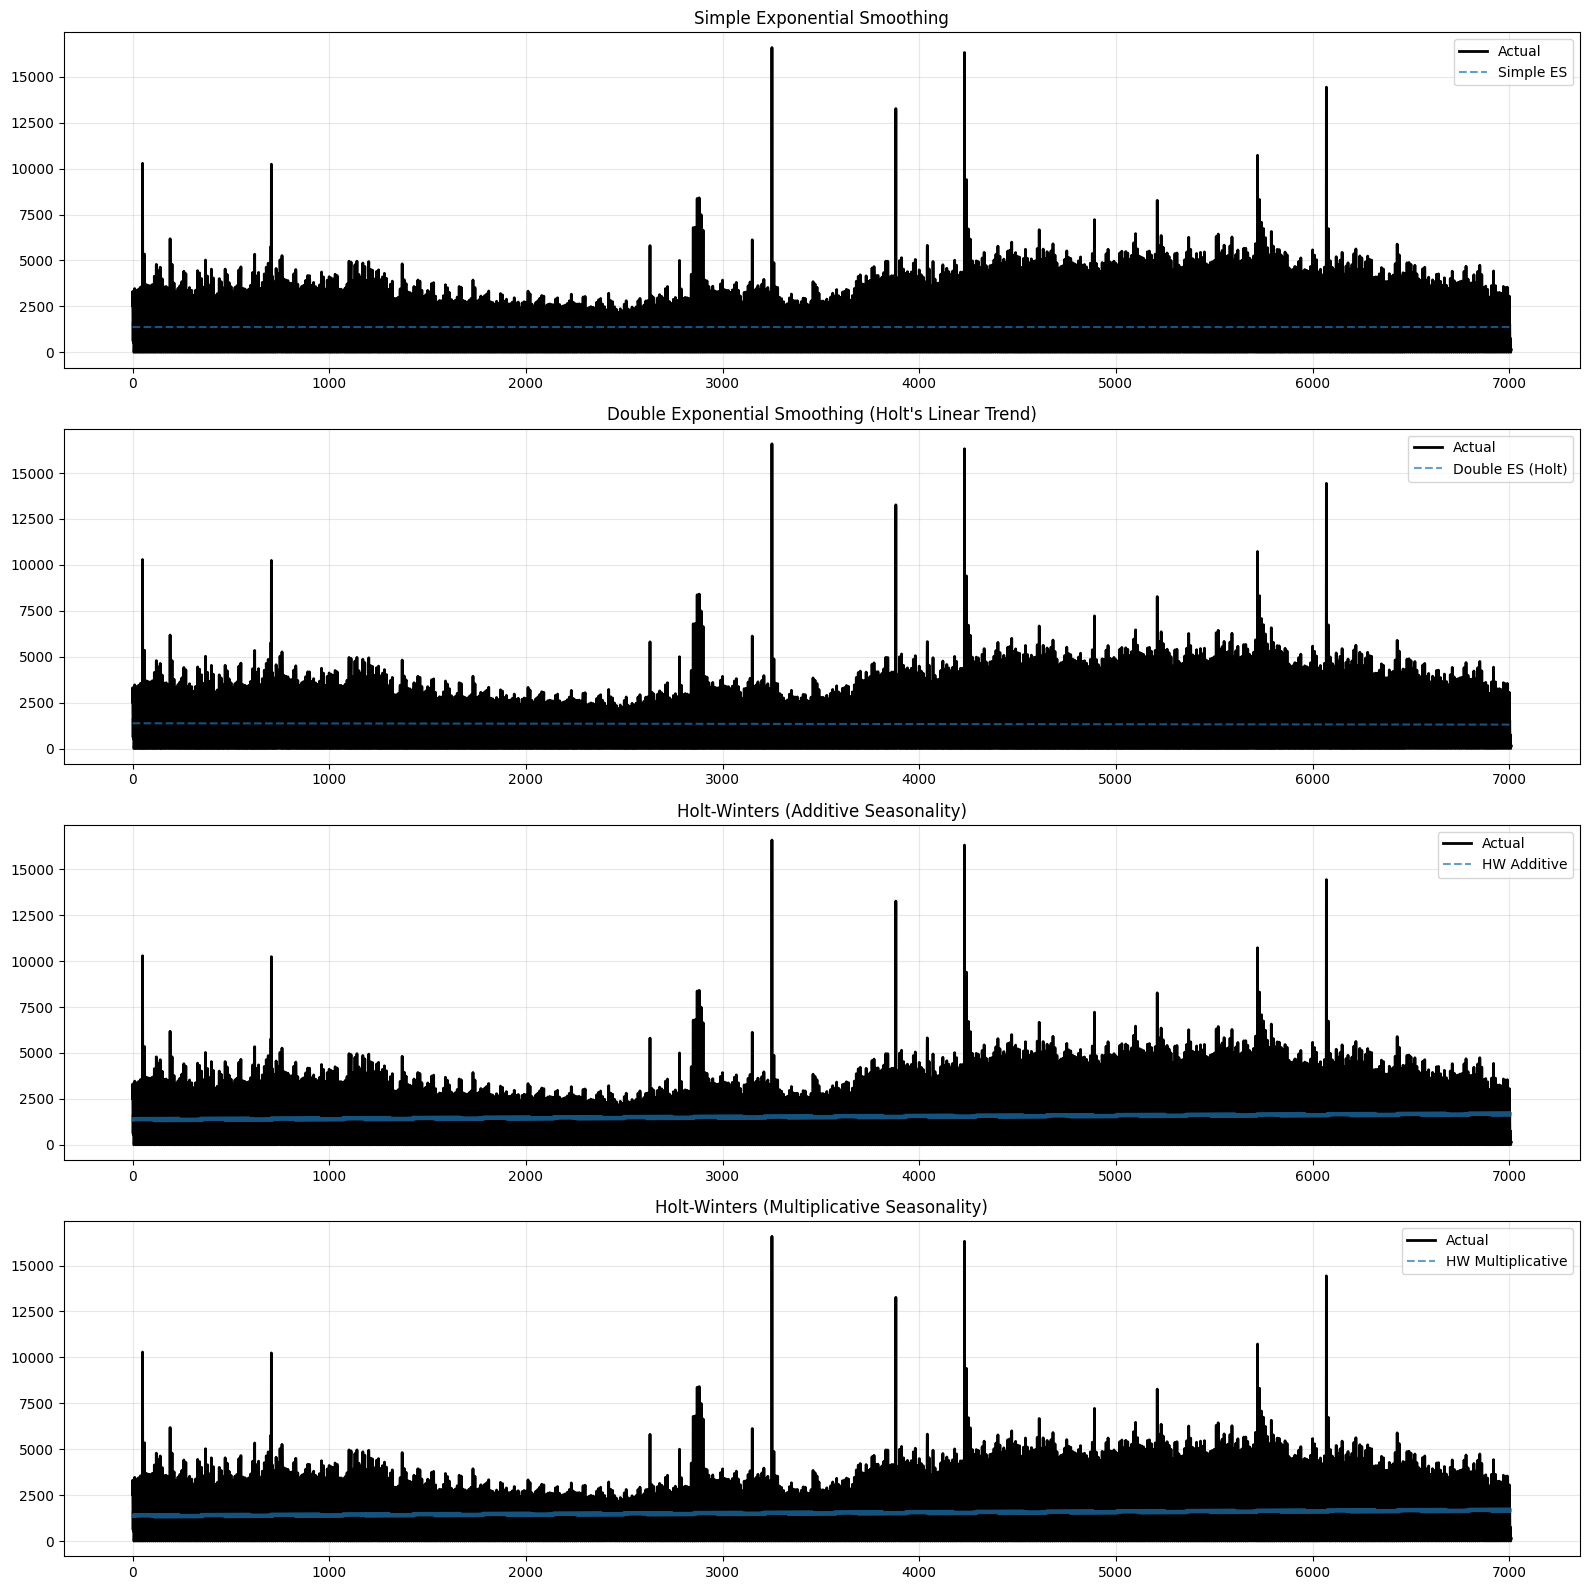

In [21]:
# Plot Exponential Smoothing models
fig, axes = plt.subplots(4, 1, figsize=(16, 16))

axes[0].plot(test_ts.values, label='Actual', linewidth=2, color='black')
axes[0].plot(ses_pred.values, label='Simple ES', alpha=0.7, linestyle='--')
axes[0].set_title('Simple Exponential Smoothing')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(test_ts.values, label='Actual', linewidth=2, color='black')
axes[1].plot(des_pred.values, label='Double ES (Holt)', alpha=0.7, linestyle='--')
axes[1].set_title('Double Exponential Smoothing (Holt\'s Linear Trend)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(test_ts.values, label='Actual', linewidth=2, color='black')
axes[2].plot(hw_add_pred.values, label='HW Additive', alpha=0.7, linestyle='--')
axes[2].set_title('Holt-Winters (Additive Seasonality)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

axes[3].plot(test_ts.values, label='Actual', linewidth=2, color='black')
axes[3].plot(hw_mul_pred.values, label='HW Multiplicative', alpha=0.7, linestyle='--')
axes[3].set_title('Holt-Winters (Multiplicative Seasonality)')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## SARIMA Models
Test Seasonal ARIMA models with different parameters.

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA (1,1,1)(1,1,1,7) - weekly seasonality
sarima_model = SARIMAX(train_ts, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
sarima_fit = sarima_model.fit(disp=False)
sarima_pred = sarima_fit.forecast(steps=len(test_ts))

results['SARIMA'] = evaluate_model(test_ts.values, sarima_pred.values, "SARIMA(1,1,1)(1,1,1,7)")

c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



SARIMA(1,1,1)(1,1,1,7) Performance:
MAE: 1124.70
RMSE: 1411.49
MAPE: inf%


c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\cleo7\AppData\Local\Temp\ipykernel_11160\2840208749.py:9: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual - predicted) / actual)) * 100


In [23]:
print(sarima_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Views   No. Observations:                12790
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood             -119454.225
Date:                           Thu, 25 Dec 2025   AIC                         238918.450
Time:                                   16:27:51   BIC                         238955.729
Sample:                                        0   HQIC                        238930.916
                                         - 12790                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0780      0.005     14.498      0.000       0.067       0.089
ma.L1         -0.9999      0.001   -711.007

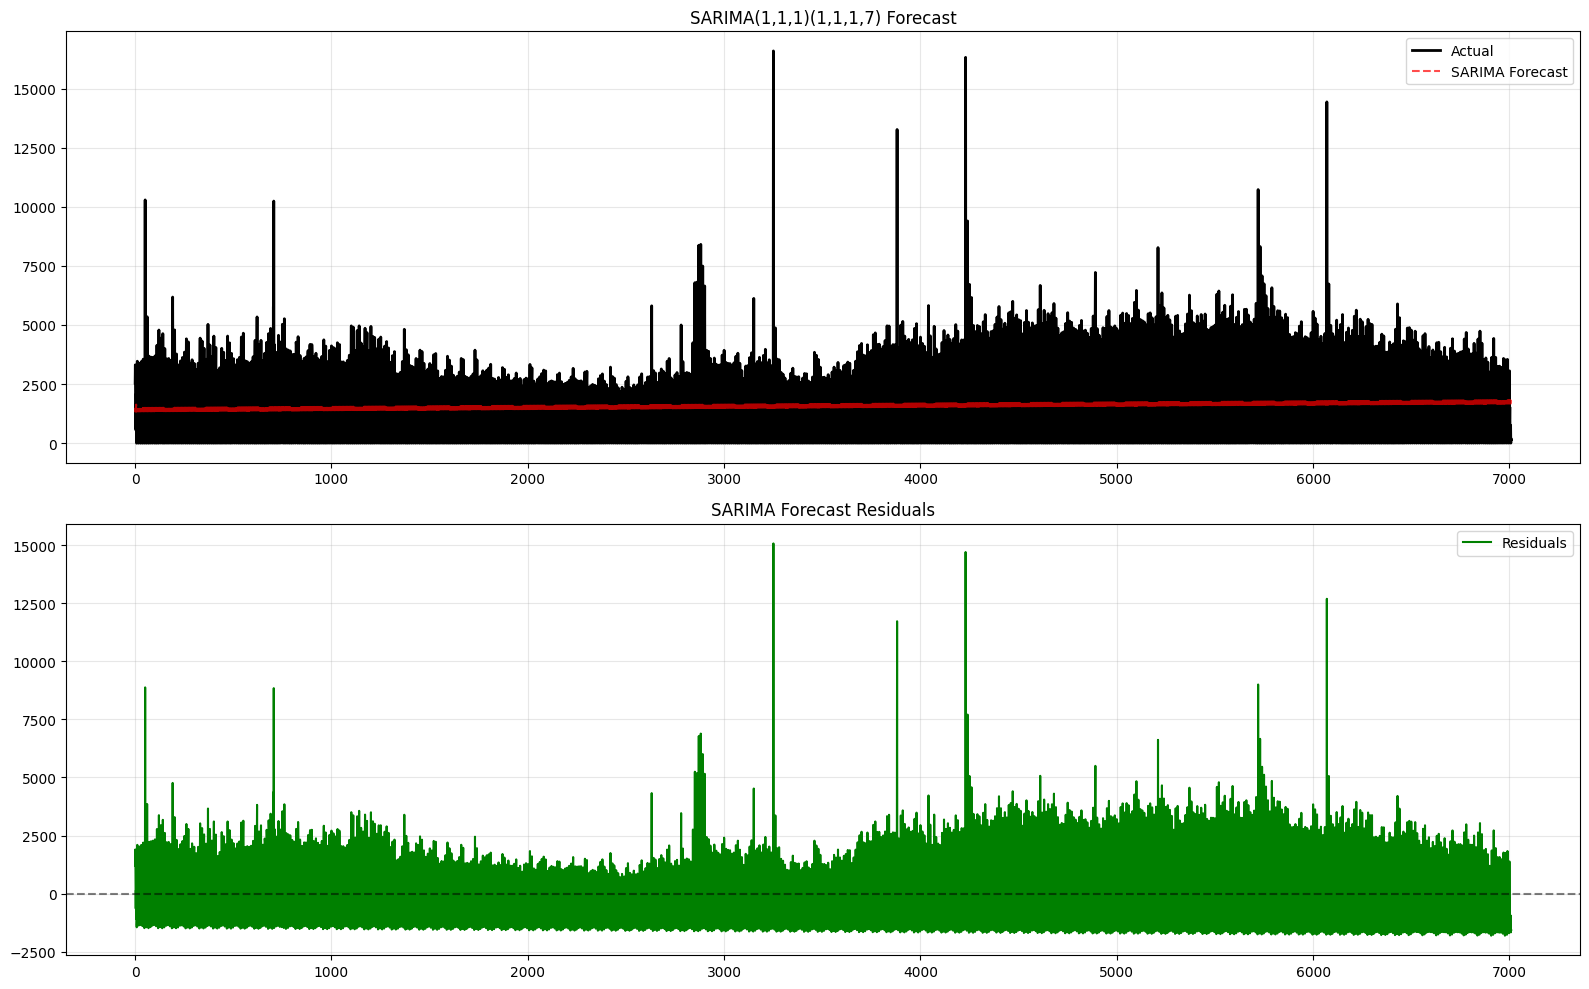

In [24]:
# Plot SARIMA results
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Forecast plot
axes[0].plot(test_ts.values, label='Actual', linewidth=2, color='black')
axes[0].plot(sarima_pred.values, label='SARIMA Forecast', alpha=0.7, linestyle='--', color='red')
axes[0].set_title('SARIMA(1,1,1)(1,1,1,7) Forecast')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residuals plot
residuals = test_ts.values - sarima_pred.values
axes[1].plot(residuals, label='Residuals', color='green')
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].set_title('SARIMA Forecast Residuals')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [25]:
# Try alternative SARIMA configurations
sarima_configs = [
    ((2, 1, 2), (1, 1, 1, 7), "SARIMA(2,1,2)(1,1,1,7)"),
    ((1, 0, 1), (1, 1, 1, 7), "SARIMA(1,0,1)(1,1,1,7)"),
    ((2, 1, 1), (2, 1, 0, 7), "SARIMA(2,1,1)(2,1,0,7)")
]

for order, seasonal_order, name in sarima_configs:
    try:
        model = SARIMAX(train_ts, order=order, seasonal_order=seasonal_order)
        fit = model.fit(disp=False)
        pred = fit.forecast(steps=len(test_ts))
        results[name] = evaluate_model(test_ts.values, pred.values, name)
    except Exception as e:
        print(f"Failed to fit {name}: {e}")

c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction


SARIMA(2,1,2)(1,1,1,7) Performance:
MAE: 1125.32
RMSE: 1411.95
MAPE: inf%


c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\cleo7\AppData\Local\Temp\ipykernel_11160\2840208749.py:9: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual - predicted) / actual)) * 100
c:\Users\cleo7\FHOOE\3.S\TSA\.ve


SARIMA(1,0,1)(1,1,1,7) Performance:
MAE: 943.74
RMSE: 1339.23
MAPE: inf%

SARIMA(2,1,1)(2,1,0,7) Performance:
MAE: 1077.05
RMSE: 1404.01
MAPE: inf%


c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\cleo7\FHOOE\3.S\TSA\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\cleo7\AppData\Local\Temp\ipykernel_11160\2840208749.py:9: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual - predicted) / actual)) * 100


## Prophet Model
Facebook's Prophet is designed for forecasting time series with strong seasonal patterns.

In [26]:
try:
    from prophet import Prophet
    
    # Prepare data for Prophet (needs 'ds' and 'y' columns)
    train_prophet = pd.DataFrame({
        'ds': train_ts.index,
        'y': train_ts.values
    })
    
    # Fit Prophet model
    prophet_model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=True,
        changepoint_prior_scale=0.05
    )
    prophet_model.fit(train_prophet)
    
    # Make predictions
    future = prophet_model.make_future_dataframe(periods=len(test_ts))
    prophet_forecast = prophet_model.predict(future)
    prophet_pred = prophet_forecast['yhat'].tail(len(test_ts)).values
    
    results['Prophet'] = evaluate_model(test_ts.values, prophet_pred, "Facebook Prophet")
    
    print("\nProphet model fitted successfully!")
    
except ImportError:
    print("Prophet not installed. Install with: pip install prophet")
except Exception as e:
    print(f"Prophet error: {e}")

Prophet not installed. Install with: pip install prophet


In [27]:
# Plot Prophet results if available
if 'Prophet' in results:
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    
    axes[0].plot(test_ts.values, label='Actual', linewidth=2, color='black')
    axes[0].plot(prophet_pred, label='Prophet Forecast', alpha=0.7, linestyle='--', color='blue')
    axes[0].set_title('Facebook Prophet Forecast')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot components
    fig2 = prophet_model.plot_components(prophet_forecast)
    plt.show()

## Model Comparison
Compare all models side by side.

In [28]:
# Create comparison DataFrame
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.sort_values('RMSE')
print("\n" + "="*60)
print("MODEL COMPARISON - Sorted by RMSE (lower is better)")
print("="*60)
print(comparison_df.to_string())
print("="*60)


MODEL COMPARISON - Sorted by RMSE (lower is better)
                                MAE         RMSE  MAPE
SARIMA(1,0,1)(1,1,1,7)   943.744651  1339.229034   inf
Double_ES               1010.276192  1357.011471   inf
Simple_ES               1026.110591  1362.938076   inf
HW_Additive             1105.640119  1400.760470   inf
HW_Multiplicative       1105.640119  1400.760470   inf
SARIMA(2,1,1)(2,1,0,7)  1077.046087  1404.010438   inf
Moving_Average           949.598431  1406.131918   inf
SARIMA                  1124.701785  1411.494646   inf
SARIMA(2,1,2)(1,1,1,7)  1125.323349  1411.952572   inf
Seasonal_Naive          1172.702568  1647.493738   NaN
Naive                   1067.886591  1671.895859   inf


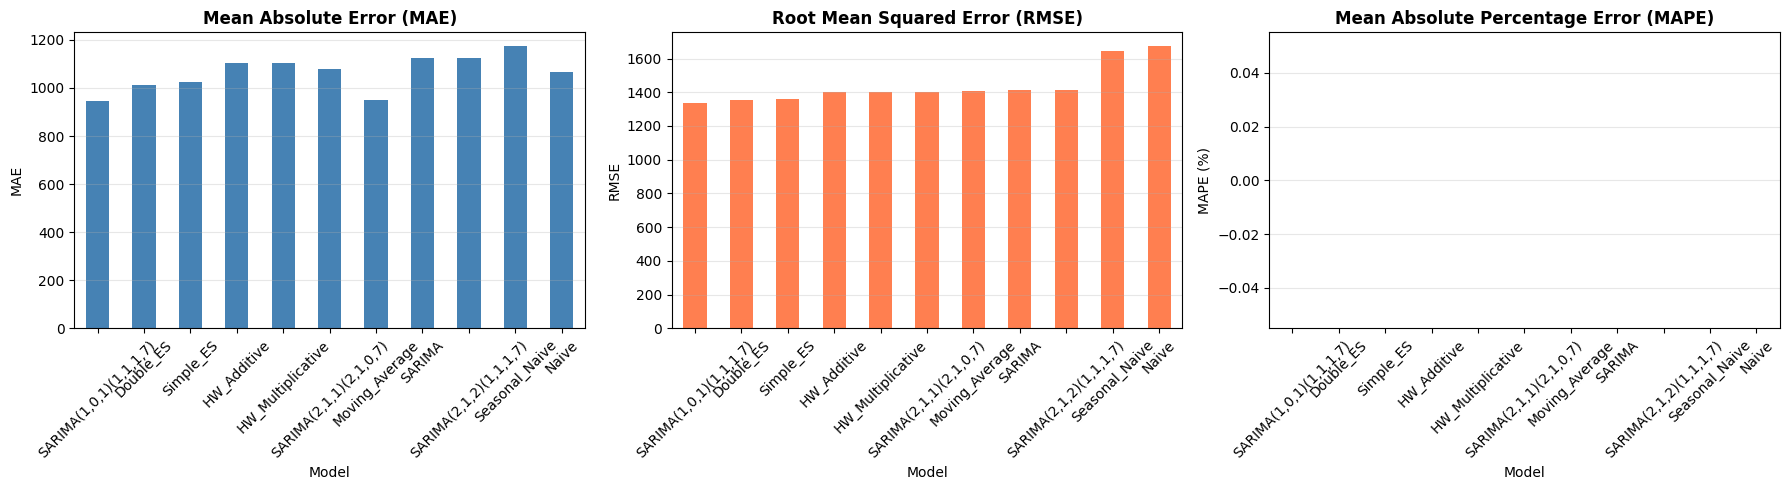

In [29]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

comparison_df.plot(kind='bar', y='MAE', ax=axes[0], legend=False, color='steelblue')
axes[0].set_title('Mean Absolute Error (MAE)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('MAE')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

comparison_df.plot(kind='bar', y='RMSE', ax=axes[1], legend=False, color='coral')
axes[1].set_title('Root Mean Squared Error (RMSE)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('RMSE')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

comparison_df.plot(kind='bar', y='MAPE', ax=axes[2], legend=False, color='lightgreen')
axes[2].set_title('Mean Absolute Percentage Error (MAPE)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Model')
axes[2].set_ylabel('MAPE (%)')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Visual Comparison of Top Models
Plot the best performing models against actual values.

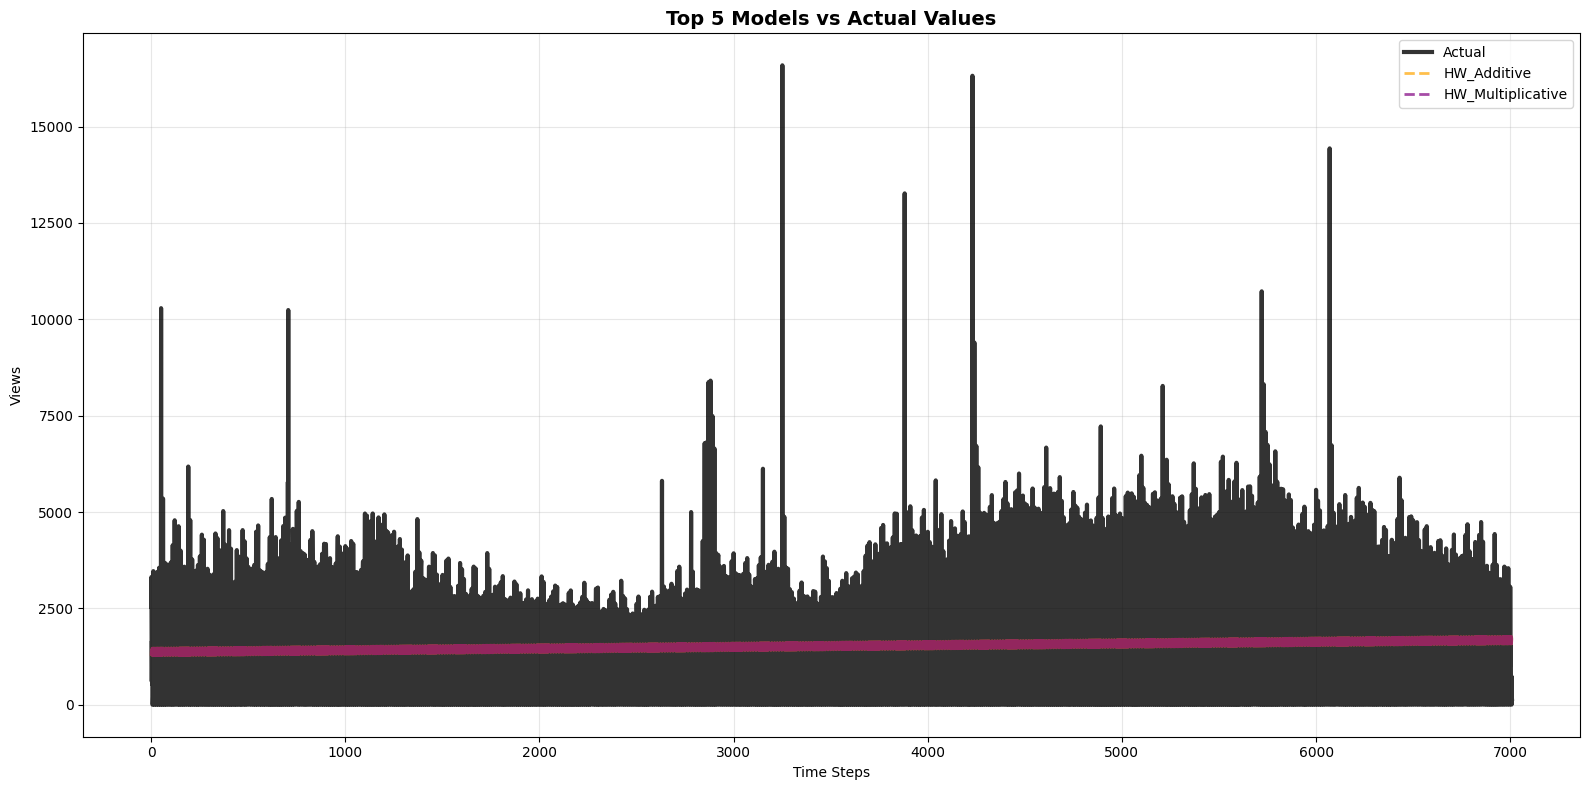

In [30]:
# Get top 5 models
top_models = comparison_df.head(5).index.tolist()

plt.figure(figsize=(16, 8))
plt.plot(test_ts.values, label='Actual', linewidth=3, color='black', alpha=0.8)

# Plot predictions from stored results
colors = ['red', 'blue', 'green', 'orange', 'purple']
for i, model_name in enumerate(top_models):
    # Re-generate predictions for top models
    if model_name == 'HW_Additive' and 'hw_add_pred' in locals():
        plt.plot(hw_add_pred.values, label=model_name, linestyle='--', alpha=0.7, linewidth=2, color=colors[i])
    elif model_name == 'HW_Multiplicative' and 'hw_mul_pred' in locals():
        plt.plot(hw_mul_pred.values, label=model_name, linestyle='--', alpha=0.7, linewidth=2, color=colors[i])
    elif model_name == 'SARIMA' and 'sarima_pred' in locals():
        plt.plot(sarima_pred.values, label=model_name, linestyle='--', alpha=0.7, linewidth=2, color=colors[i])
    elif model_name == 'Prophet' and 'prophet_pred' in locals():
        plt.plot(prophet_pred, label=model_name, linestyle='--', alpha=0.7, linewidth=2, color=colors[i])

plt.title('Top 5 Models vs Actual Values', fontsize=14, fontweight='bold')
plt.xlabel('Time Steps')
plt.ylabel('Views')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()